In [3]:
import json, os, pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mlp import MLP1, MLP2, MLP3, encode_data, fix_random_seed

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [5]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [6]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_cliffords/', '.pk')
print(len(train_circuits))

# test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_cliffords/val/', '.pk')
# print(len(test_circuits))

  0%|          | 0/10 [00:00<?, ?it/s]

5000


In [8]:
# to_save = {'train_circuits': train_circuits,
#            'train_ideal_exp_vals': train_ideal_exp_vals,
#            'train_noisy_exp_vals': train_noisy_exp_vals,
#            'test_circuits': test_circuits,
#            'test_ideal_exp_vals': test_ideal_exp_vals,
#            'test_noisy_exp_vals': test_noisy_exp_vals}
# with open('./data/mbd_datasets2/theta_0.05pi/circuits.pk', 'wb') as out:
#     pickle.dump(to_save, out)

with open('./data/mbd_datasets2/theta_0.05pi/circuits.pk', 'rb') as infile:
    loaded = pickle.load(infile)

train_circuits += loaded['train_circuits']
test_circuits = loaded['test_circuits']
train_ideal_exp_vals += loaded['train_ideal_exp_vals']
train_noisy_exp_vals += loaded['train_noisy_exp_vals']
test_ideal_exp_vals = loaded['test_ideal_exp_vals']
test_noisy_exp_vals = loaded['test_noisy_exp_vals']

In [9]:
print(len(train_circuits), len(train_ideal_exp_vals), len(train_noisy_exp_vals))

10000 10000 10000


In [10]:
train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals]
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=4)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=4)

In [11]:
BATCH_SIZE = 32
fix_random_seed(0)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 0


In [12]:
fix_random_seed(0)
model = MLP3(
    input_size=58,
    output_size=4,
    hidden_size=128
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                            'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

random seed fixed to 0


In [13]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(len(train_loader) * BATCH_SIZE, len(test_loader) * BATCH_SIZE)

30166
10016 32


In [15]:
fix_random_seed(0)

train_losses = []
test_losses = []

N_EPOCHS = 100

progress = tqdm(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    test_loss = 0.0
    model.eval()
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

    scheduler.step(test_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(test_losses[-1], 5)}")
        progress.refresh()

random seed fixed to 0


Model training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00051: reducing learning rate of group 0 to 1.0000e-05.


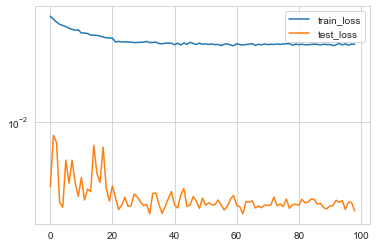

In [17]:
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.yscale('log')

plt.style.use({'figure.facecolor':'white'})
plt.legend()
plt.show()

In [26]:
# model_path = './model/haoran_mbd2/mlp2_random_cliffords.pth'
# model_path = './model/haoran_mbd2/mlp2_random_brickwork.pth'
# model_path = './model/haoran_mbd2/mlp2_mbd.pth'
# model_path = './model/haoran_mbd2/mlp2_cliffords_and_mbd2.pth'
model_path = './model/haoran_mbd2/mlp3_cliffords_and_mbd.pth'

In [19]:
# print('saved:', model_path)
# torch.save(model.state_dict(), model_path)

saved: ./model/haoran_mbd2/mlp3_cliffords_and_mbd.pth


In [20]:
# import pickle
#
# to_save = {'train_losses': train_losses, 'val_losses': test_losses}
# with open('.'+model_path.split('.')[1]+'.pk', 'wb') as handle:
#     pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# with open('.'+model_path.split('.')[1]+'.pk', 'rb') as in_f:
#     loaded_plot = pickle.load(in_f)
# train_losses = loaded_plot['train_losses']
# test_losses = loaded_plot['val_losses']

In [27]:
model = MLP3(
    input_size=58,
    output_size=4,
    hidden_size=128
)
print('loade:', model_path)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()

loade: ./model/haoran_mbd2/mlp3_cliffords_and_mbd.pth


MLP3(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=42, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=42, out_features=4, bias=True)
)

random seed fixed to 0


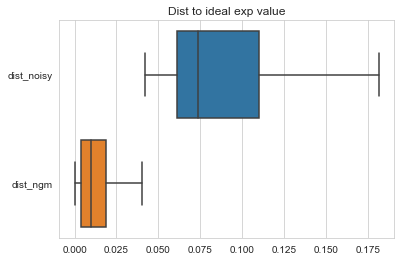

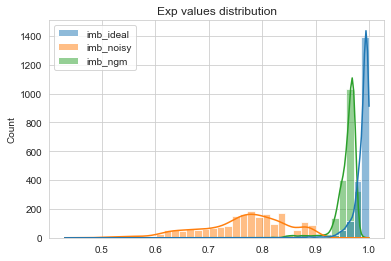

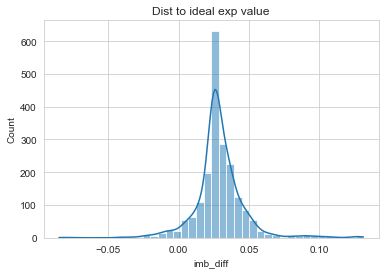

In [29]:
fix_random_seed(0)

model.eval()
distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for batch_X, batch_y in test_loader:
    out = model(batch_X)

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -4:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
            "imb_ideal": imbalance_ideal,
            "imb_noisy": imbalance_noisy,
            "imb_ngm": imbalance_mitigated,
            "imb_diff": imbalance_ideal - imbalance_mitigated
        })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

# sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
# plt.title("Exp values distribution")
# plt.show()

sns.histplot([df['imb_ideal'], df['imb_noisy'], df["imb_ngm"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

sns.histplot(data=df["imb_diff"], kde=True, bins=40)
plt.title("Dist to ideal exp value")
plt.show()

In [25]:
## Now we need to average over many disorders
num_disorders = 10

num_spins = 4 # Number of spins. Must be even.
W = 0.8 * np.pi # Disorder strength up to np.pi
theta = 0.05 * np.pi # Interaction strength up to np.pi
max_steps = 5

even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated = []

for disorder_realization in tqdm(range(num_disorders)):
    disorders = generate_disorder(num_spins, W)
    # print(disorders)

    qc_list = []
    for steps in range(max_steps):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated = []

    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        # print(entry.batch)
        X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)
        mitigated_exp_val = model(X).tolist()[0]

        exp_Z_mitigated.append(mitigated_exp_val)

    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)

    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated.append(imbalance_mitigated)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average = np.mean(imbalance_all_mitigated, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

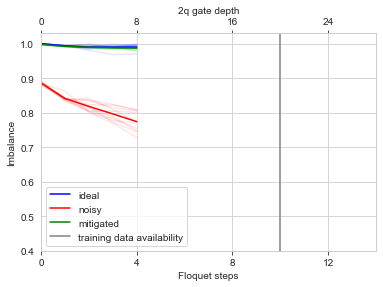

In [21]:
## Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for disorder_realization in range(num_disorders):
    ax1.plot(imbalance_all_ideal[disorder_realization], color=(0.0, 0.0, 1.0, 0.1))
    ax1.plot(imbalance_all_noisy[disorder_realization], color=(1.0, 0.0, 0.0, 0.1))
    ax1.plot(imbalance_all_mitigated[disorder_realization], color=(0.0, 1.0, 0.0, 0.1))

ax1.plot(imbalance_ideal_average, color='blue', label="ideal")
ax1.plot(imbalance_noisy_average, color='red', label="noisy")
ax1.plot(imbalance_mitigated_average, color='green', label="mitigated")

ax1.axvline(x = 10, color = 'gray', label = 'training data availability')

ax1.set_xlabel('Floquet steps')
ax1.set_ylabel('Imbalance')
ax1.legend()

xmin,xmax = ax1.get_xlim()
max_x = max_steps + 10
ax1.set_xlim([0, max_x-1])
ax2.set_xlim([0, max_x-1])
ax1.set_ylim([0.4, 1.03])
ax1.set_xticks(np.arange(0, max_x, 4))
x2 = np.linspace(xmin, xmax, 50)
ax2.plot(x2, -np.ones(50)) # Create a dummy plot
ax2.set_xticks(np.arange(0, max_x, 4))
ax2.set_xticklabels(2*np.arange(0, max_x, 4))
ax2.set_xlabel(r"2q gate depth")
# ax1.grid(None)
ax2.grid(None)

plt.style.use({'figure.facecolor':'white'})
plt.show()